In [68]:
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [69]:
print(torch.__version__)
print(np.__version__)

2.1.2+cu118
1.24.1


In [70]:
# setup the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [71]:
# get and download the dataset
# we're going to use subsets of Food101 dataset

import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists ...")
else:
    print(f"{image_path} doesn't exist, creating one ...")
    image_path.mkdir(parents=True, exist_ok=True)


# download the dataset
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading the dataset ...")
    f.write(request.content)


# unzip the downloaded datadet
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unziping the dataset ...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists ...
Unziping the dataset ...


In [72]:
# data preparation and exploration
import os

def walk_through_dir(dir_path):
    """Walks through dir_path returing it's content

    Args:
        dir_path (str): _description_
    """
    
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [73]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [74]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'


In [75]:
# setup the train and test path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Path: data\pizza_steak_sushi\train\pizza\1968947.jpg
Image class: pizza
Image height: 512
Image width: 512


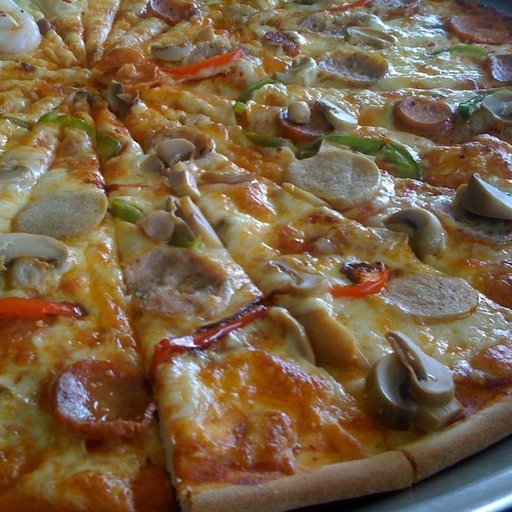

In [76]:
# visualizing an image
import random
from PIL import Image

# get all the image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# select a random image path
random_image_path = random.choice(image_path_list)
print(f"Path: {random_image_path}")

# get the image class
image_class = random_image_path.parent.stem
print(f"Image class: {image_class}")

# open the image
img = Image.open(random_image_path)
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

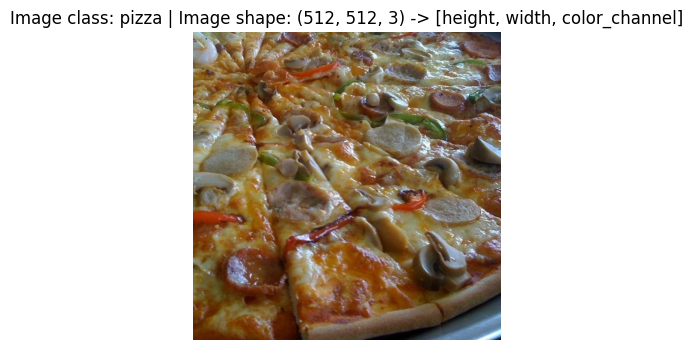

In [77]:
# try to visualize the image using matplotlib
import numpy as np
import matplotlib.pyplot as plt

# convert the image to numpy array
image_array = np.asarray(img)

# let's visualize the image
plt.figure(figsize=(6, 4))
plt.imshow(image_array)
plt.title(f"Image class: {image_class} | Image shape: {image_array.shape} -> [height, width, color_channel]")
plt.axis(False)
plt.show()

In [78]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [79]:
import os
import pathlib
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import List, Tuple, Dict

In [80]:
# create a custon `Dataset` to replicate `ImageFolder`
# to create our own custom dataset we should subclass `torch.utils.data.Dataset`
# write a custom dataset class

class ImageFolderCustom(Dataset):
    
    def __init__(self, target_dir: str, transform: torchvision.transforms=None):
        super().__init__()
        
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_indx = self.find_classes(target_dir)
    
    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        """_summary_

        Args:
            directory (str): _description_

        Returns:
            Tuple[List[str], Dict[str, int]]: _description_
        """
    
        # get the class names
        classes = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir())

        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check the file structure")

        # create a dictionary to index label
        class_to_indx = {class_name: i for i, class_name in enumerate(classes)}

        return classes, class_to_indx
    
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """_summary_

        Args:
            index (int): _description_

        Returns:
            Tuple[torch.Tensor, int]: One sample data i.e data and label (X, y)
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.name  # expect to have path in format: data_folder/class_name/image.jpg
        class_indx = self.class_to_indx[class_name]
        
        if self.transform:
            return self.transform(img), class_indx
        
        return img, class_indx  # return untransformed image and label

In [81]:
# data augmentation
# create a train transformation

train_transform = transforms.Compose([
    # resize the image to 256X256
    transforms.Resize(size=(256, 256)),
    
    # flip the image randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    
    #transforms.RandomRotation(10),
    #transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    
    # turn the image into torch.Tensor
    transforms.ToTensor()
])


test_transform = transforms.Compose([
    # resize the image to 256X256
    transforms.Resize(size=(256, 256)),
    
    # turn the image into torch.Tensor
    transforms.ToTensor()
])

In [82]:
train_transform, test_transform

(Compose(
     Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
     RandomHorizontalFlip(p=0.5)
     ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=None, hue=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
 ))

In [83]:
# create train and test data
train_data_custom = ImageFolderCustom(
    target_dir=train_dir,
    transform=train_transform
)

test_data_custom = ImageFolderCustom(
    target_dir=test_dir,
    transform=test_transform
)

In [84]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x297861693d0>,
 <__main__.ImageFolderCustom at 0x29785711ed0>)

In [85]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [86]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [87]:
train_data_custom.class_to_indx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [88]:
img, label = train_data_custom[3]
img

tensor([[[0.2980, 0.3059, 0.3176,  ..., 0.0667, 0.0706, 0.0627],
         [0.3176, 0.3176, 0.3176,  ..., 0.0667, 0.0706, 0.0627],
         [0.3176, 0.3255, 0.3176,  ..., 0.0627, 0.0627, 0.0549],
         ...,
         [0.6941, 0.7059, 0.6863,  ..., 0.3412, 0.3294, 0.3216],
         [0.7216, 0.7216, 0.7098,  ..., 0.3451, 0.3137, 0.3176],
         [0.7216, 0.7137, 0.7216,  ..., 0.3137, 0.3294, 0.3059]],

        [[0.3647, 0.3686, 0.3765,  ..., 0.0627, 0.0627, 0.0510],
         [0.3765, 0.3765, 0.3765,  ..., 0.0627, 0.0627, 0.0510],
         [0.3804, 0.3882, 0.3804,  ..., 0.0549, 0.0549, 0.0471],
         ...,
         [0.8392, 0.8549, 0.8275,  ..., 0.3647, 0.3490, 0.3333],
         [0.8588, 0.8627, 0.8471,  ..., 0.3686, 0.3294, 0.3333],
         [0.8549, 0.8510, 0.8549,  ..., 0.3373, 0.3490, 0.3216]],

        [[0.5020, 0.5059, 0.5176,  ..., 0.0627, 0.0667, 0.0549],
         [0.5176, 0.5176, 0.5176,  ..., 0.0627, 0.0667, 0.0549],
         [0.5176, 0.5255, 0.5176,  ..., 0.0627, 0.0627, 0.

In [89]:
img.shape

torch.Size([3, 256, 256])

In [90]:

def display_random_images(dataset: torch.utils.data.Dataset, classes: List[str],
                            n: int=10, display_shape: bool=True, seed: int=None):
    
    # 2. Adjust display if n too high
    if n >= 5:
        n = 5
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 5, setting to 5 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

For display purposes, n shouldn't be larger than 5, setting to 5 and removing shape display.


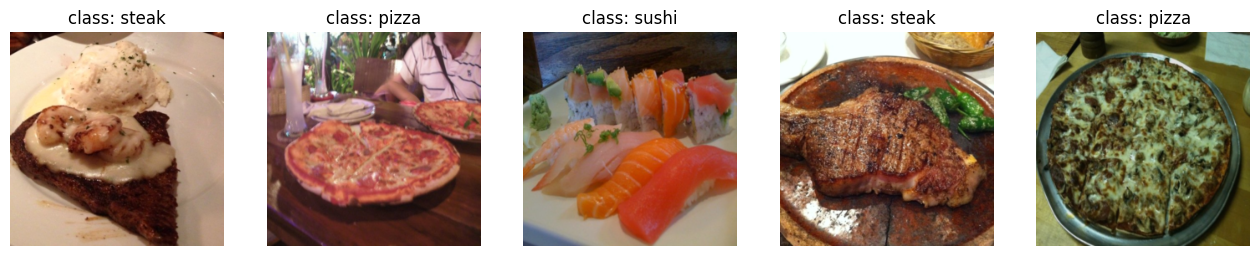

In [91]:
# train data
display_random_images(
    dataset=train_data_custom,
    classes=train_data_custom.classes,
    n=5,
    display_shape=True,
    seed=None
)

For display purposes, n shouldn't be larger than 5, setting to 5 and removing shape display.


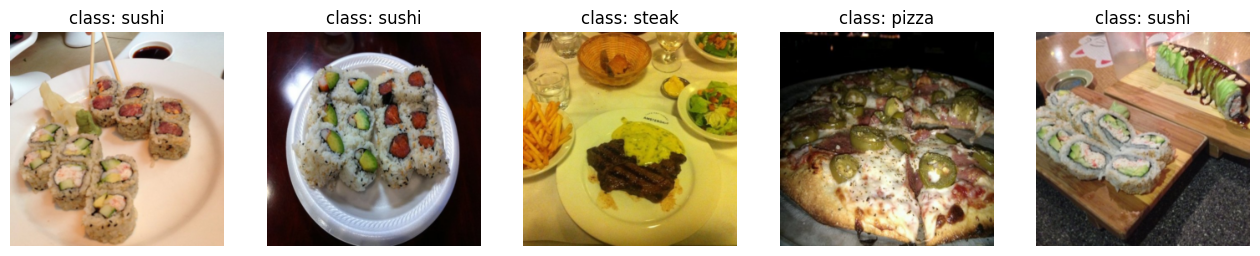

In [92]:
# test data
display_random_images(
    dataset=test_data_custom,
    classes=test_data_custom.classes,
    n=5,
    display_shape=True,
    seed=None
)

In [93]:
# now, turn the  train and test dataset into dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data_custom,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data_custom,
    batch_size=BATCH_SIZE
)

In [94]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [95]:
images, labels = next(iter(train_dataloader))
images.shape # [batch_size, C, H, W]

torch.Size([32, 3, 256, 256])

In [96]:
labels.shape

torch.Size([32])

In [97]:
# creating a helper function to get class names

target_dir = train_dir

class_names = sorted([entry.name for entry in list(os.scandir(target_dir))])
class_names

['pizza', 'steak', 'sushi']

In [110]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

In [112]:
type(ResNet18_Weights.IMAGENET1K_V1)

<enum 'ResNet18_Weights'>

In [116]:
type(ResNet18_Weights.IMAGENET1K_V1.value)

torchvision.models._api.Weights

In [99]:

class FoodModel(nn.Module):
    def __init__(self, output_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Load the pretrained ResNet18 model
        # self.base_model = models.resnet18(pretrained=True) -> deprecated 
        self.base_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  # Updated to use weights
        
        # Remove the fully connected layer from ResNet18
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-2])  # Keep the spatial dimensions (8x8)

        # Freeze the parameters of ResNet18 to prevent training
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Custom convolutional layers
        self.custom_layers = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Conv1-512
            nn.ReLU(),
            nn.Conv2d(512, 32, kernel_size=3, padding=1),   # Conv2-32
            nn.ReLU(),
            nn.Conv2d(32, 6, kernel_size=3, padding=1),     # Conv3-6
            nn.ReLU()
        )

        # Fully connected layer
        self.flatten = nn.Flatten()
        # Dynamically calculate the input size to the fully connected layer
        self.fc = nn.Linear(6 * 8 * 8, output_classes)

    def forward(self, x):
        x = self.base_model(x)  # Pass through ResNet18 (Output: [B, 512, 8, 8])
        x = self.custom_layers(x)  # Pass through custom conv layers (Output: [B, 6, 8, 8])
        x = self.flatten(x)  # Flatten (Output: [B, 6 * 8 * 8])
        x = self.fc(x)  # Fully connected layer (Output: [B, output_classes])
        return x

In [100]:
model = FoodModel(
    output_classes=len(class_names)
).to(device)

In [101]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [102]:
from torchinfo import summary

summary(model, input_size=[1, 3, 256, 256])

Layer (type:depth-idx)                        Output Shape              Param #
FoodModel                                     [1, 3]                    --
├─Sequential: 1-1                             [1, 512, 8, 8]            --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         (128)
│    └─ReLU: 2-3                              [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                         [1, 64, 64, 64]           --
│    └─Sequential: 2-5                        [1, 64, 64, 64]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 64, 64]           (73,984)
│    │    └─BasicBlock: 3-2                   [1, 64, 64, 64]           (73,984)
│    └─Sequential: 2-6                        [1, 128, 32, 32]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 32, 32]          (230,144)
│    │    └─BasicBlock: 3-4                   [1, 128, 32, 32]      

In [103]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [104]:

def train_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                train_loss_accum: list,
                train_acc_accum: list,
                device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.to(device)
    
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_logit = model(X)
        
        y_proba = torch.softmax(y_logit, dim=1)
        y_pred = y_proba.argmax(dim=1)

        # 2. Calculate loss
        loss = loss_fn(y_logit, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                y_pred=y_pred) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    train_loss_accum.append(train_loss.item())
    train_acc_accum.append(train_acc/100.0)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    
    

def test_step(data_loader: torch.utils.data.DataLoader,
                model: torch.nn.Module,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                test_loss_accum: list,
                test_acc_accum: list,
                device: torch.device = device):
    
    test_loss, test_acc = 0, 0
    model.to(device)
    
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_logit = model(X)
            test_proba = torch.softmax(test_logit, dim=1)
            test_pred = test_proba.argmax(dim=1)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_logit, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        test_loss_accum.append(test_loss.item())
        test_acc_accum.append(test_acc/100.0)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [105]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    
    return total_time

In [106]:
from tqdm.auto import tqdm # type: ignore

# Measure time
from timeit import default_timer as timer
train_time_start_model = timer()

model = FoodModel(
    output_classes=len(class_names)
).to(device)

# Train and test model 
epochs = 20

# list to store train and test loss, accuracy
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                        betas=(0.9, 0.999),
                        lr=0.0001)

# optimizer = torch.optim.SGD(params=model_0.parameters(),
#                         lr=0.1)

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_step(data_loader=train_dataloader, 
        model=model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        train_loss_accum=train_losses,
        train_acc_accum=train_accuracies,
        device=device
    )
    
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        test_loss_accum=test_losses,
        test_acc_accum=test_accuracies,
        device=device
    )

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                        end=train_time_end_model,
                                        device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09679 | Train accuracy: 33.98%
Test loss: 1.00686 | Test accuracy: 66.76%

Epoch: 1
---------
Train loss: 0.99810 | Train accuracy: 57.81%
Test loss: 0.91296 | Test accuracy: 73.20%

Epoch: 2
---------
Train loss: 0.84834 | Train accuracy: 82.81%
Test loss: 0.74613 | Test accuracy: 85.51%

Epoch: 3
---------
Train loss: 0.61843 | Train accuracy: 85.94%
Test loss: 0.79221 | Test accuracy: 67.23%

Epoch: 4
---------
Train loss: 0.44664 | Train accuracy: 89.06%
Test loss: 0.58055 | Test accuracy: 78.41%

Epoch: 5
---------
Train loss: 0.32903 | Train accuracy: 90.62%
Test loss: 0.37244 | Test accuracy: 87.59%

Epoch: 6
---------
Train loss: 0.25955 | Train accuracy: 91.80%
Test loss: 0.46426 | Test accuracy: 83.62%

Epoch: 7
---------
Train loss: 0.18805 | Train accuracy: 95.70%
Test loss: 0.44473 | Test accuracy: 82.58%

Epoch: 8
---------
Train loss: 0.17135 | Train accuracy: 94.92%
Test loss: 0.69009 | Test accuracy: 69.22%

Epoch: 9
---------
Train los

In [107]:
from utils import plot_training_history

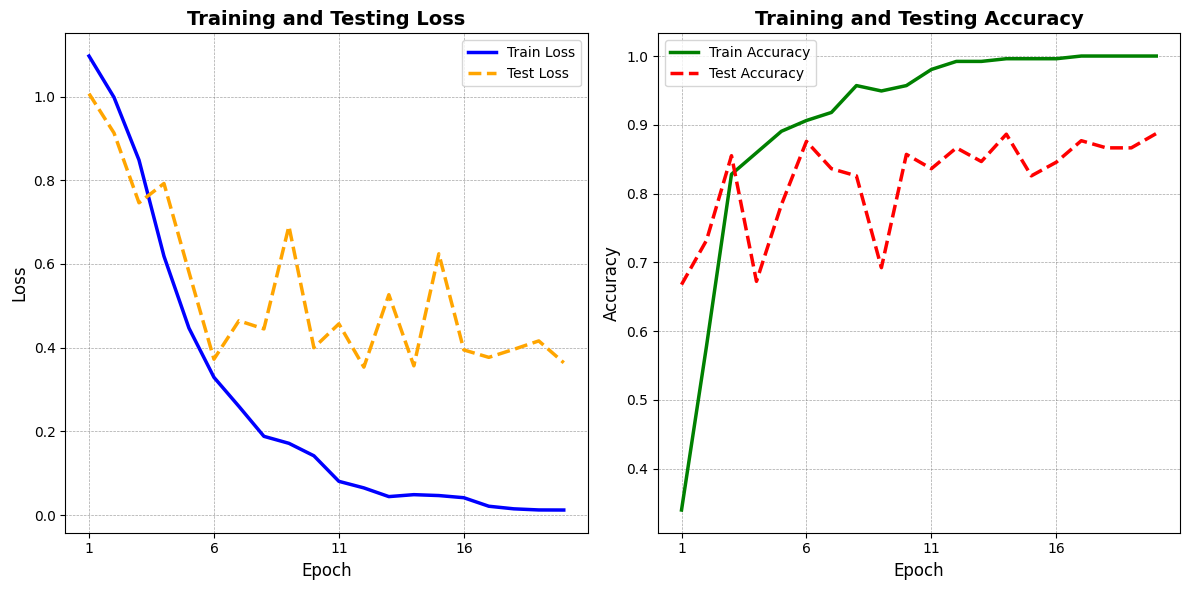

In [108]:
plot_training_history(
    epochs=epochs,
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)